In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
import json



In [3]:
from utils.utils import make_bar_plot, get_high_season

In [4]:
base_color = '#3B3B3B'

In [5]:
data_dir = 'data/raw/'
data_file = 'dataset_SCL.csv'

# use pathlib to create a path to the data file 
data_path = Path(data_dir + data_file)

In [65]:
df = pd.read_csv(data_path,low_memory=False) 
df.head()


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [66]:
df.nunique()

Fecha-I      53252
Vlo-I          584
Ori-I            1
Des-I           64
Emp-I           30
Fecha-O      62774
Vlo-O          861
Ori-O            1
Des-O           63
Emp-O           32
DIA             31
MES             12
AÑO              2
DIANOM           7
TIPOVUELO        2
OPERA           23
SIGLAORI         1
SIGLADES        62
dtype: int64

### Question 1: How is the data distributed? Did you find any noteworthy insight to share? What can you conclude about this?


In [7]:
df.isnull().sum().to_frame().T

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [8]:
df[df.isnull().any(axis=1)]


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,19,1,2017,Jueves,I,Latin American Wings,Santiago,Lima


In [9]:
ratio = df.nunique() / df.shape[0]
display(ratio.to_frame().T)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,0.780752,0.008562,0.000015,0.000938,0.00044,0.920359,0.012624,0.000015,0.000924,0.000469,0.000455,0.000176,0.000029,0.000103,0.000029,0.000337,0.000015,0.000909


In [10]:
# since there is only one missing value we can drop the row 
df = df.dropna()

In [11]:
df.dtypes.to_frame().T


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,object,object,object,object,object,object,object,object,object,object,int64,int64,int64,object,object,object,object,object


In [12]:
# conver the date columns to datetime (Fecha-I	 and Fecha-O) 
df['Fecha-I'] = pd.to_datetime(df['Fecha-I'])
df['Fecha-O'] = pd.to_datetime(df['Fecha-O'])


In [13]:
df.dtypes.to_frame().T


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,datetime64[ns],object,object,object,object,datetime64[ns],object,object,object,object,int64,int64,int64,object,object,object,object,object


In [14]:
# create two new columns for the year and month  
df['year'] = df['Fecha-I'].dt.year
df['month'] = df['Fecha-I'].dt.month


## Univariate analysis 

In [15]:
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,year,month
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,2017,1
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami,2017,1
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami,2017,1
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami,2017,1
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami,2017,1


I'll start looking for patterns in the data that may help to create decide the data transformation steps.


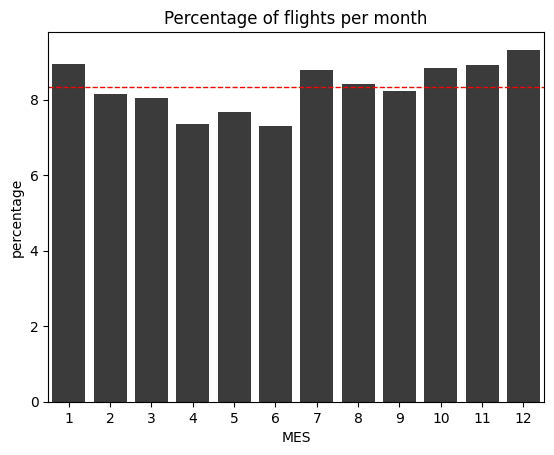

In [16]:
# From the above plot we can see that the number of flights is not evenly distributed over the months. 
# It seems to be some seasonal pattern, since the months with the highest number of flights are the consecutive (October, November, December and January) this could be due to the summer and vacation season in Chile 

make_bar_plot(df,'MES','Percentage of flights per month')

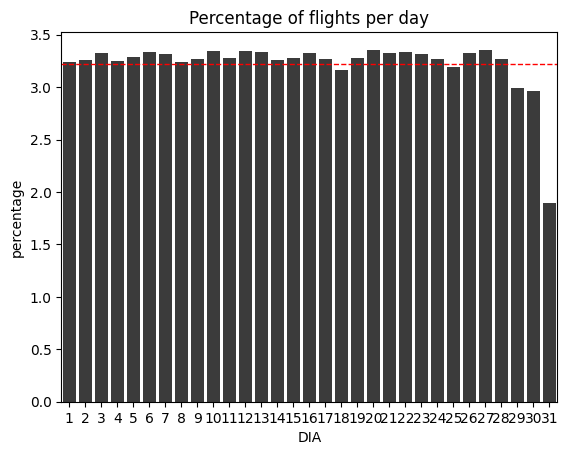

In [17]:
make_bar_plot(df,'DIA','Percentage of flights per day')

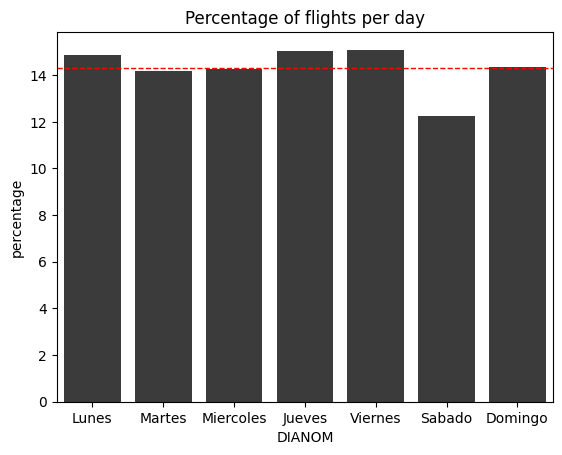

In [18]:
# For the days we can see an interesting pattern,
# the number of fligths on monday is the higher than the average which could be related to work, to take the most of the weekdays  
# a similar pattern is observed on thrusday and friday which could be related to travel for the weekend 

day_map = {'Lunes':1, 'Martes':2, 'Miercoles':3, 'Jueves':4, 'Viernes':5, 'Sabado':6, 'Domingo':7}

make_bar_plot(df,'DIANOM','Percentage of flights per day',day_map)

In [19]:
# The Scheduled fligths have 116 more unique values than the actual fligths, 
# this could have a correlation with the delay of the fligths 

print ("'Vlo-I ' has {} unique values".format(df['Vlo-I'].nunique()))
display (df['Vlo-I'].value_counts(dropna=False).to_frame().T)

print ("'Vlo-O ' has {} unique values".format(df['Vlo-O'].nunique()))
display (df['Vlo-O'].value_counts(dropna=False).to_frame().T)

'Vlo-I ' has 584 unique values


,174,11,116,150,704,162,164,118,172,170,...,1218,1906,1158,1154,1351,1121,1116,1065,1054,1234
Vlo-I,686,645,608,557,556,553,550,508,498,495,...,1,1,1,1,1,1,1,1,1,1


'Vlo-O ' has 861 unique values


,174,11,116,150,704,162,164,118,172,170,...,9701,9662,9629,9600,9956,2726,9860,9858,1297,1134
Vlo-O,649,646,608,517,514,512,508,507,466,452,...,1,1,1,1,1,1,1,1,1,1


In [20]:
# The variables 'Vlo-I' and 'Vlo-O' are constant, hence we will not use them in the rest of the analysis 

display (df['Ori-I'].value_counts(dropna=False).to_frame().T)

display (df['Ori-O'].value_counts(dropna=False).to_frame().T)


df = df.drop(['Vlo-I','Vlo-O'],axis=1) 

,SCEL
Ori-I,68205


,SCEL
Ori-O,68205


In [21]:
# At first glance we can see there are a few differences between Des-I and Des-O, 
# this could be relevant for stimated delays 

display (df['Des-I'].value_counts(dropna=False).to_frame().T)

display (df['Des-O'].value_counts(dropna=False).to_frame().T)

,SCFA,SPJC,SCCF,SCTE,SCIE,SCDA,SBGR,SAEZ,SABE,SCQP,...,SULS,SBCT,SAZS,SLCB,EGYP,SBFI,SPSO,SEQU,SEQM,SARI
Des-I,5787,5269,5145,4357,3995,3747,3570,3240,3094,2583,...,6,3,2,1,1,1,1,1,1,1


,SCFA,SPJC,SCCF,SCTE,SCIE,SCDA,SBGR,SAEZ,SABE,SCQP,...,SULS,SAWH,SBCT,SBFI,SAZS,SEQM,KIAD,SPSO,EGYP,SLCB
Des-O,5786,5269,5146,4357,3993,3747,3569,3241,3094,2589,...,6,6,3,2,2,2,1,1,1,1


In [22]:
# We can see that there are significant discrepancies between Emp-I and Emp-O

display (df['Emp-I'].value_counts(dropna=False).to_frame().T    )

display (df['Emp-O'].value_counts(dropna=False).to_frame().T)

,LAN,SKU,TAM,ARG,CMP,LAW,AVA,JAT,GLO,AAL,...,BAW,QFU,JMR,LRC,AUT,PUE,LXP,LPE,DSM,LNE
Emp-I,37611,14298,3049,1949,1850,1573,1152,1095,806,757,...,205,195,100,92,74,49,9,4,2,1


,LAN,LXP,SKU,TAM,ARG,CMP,JMR,LPE,JAT,AVA,...,AZA,KLM,LAP,BAW,QFA,AUT,PUE,56R,48O,TPU
Emp-O,20988,14558,14298,3046,1946,1850,1647,1214,1095,885,...,259,251,219,205,195,77,49,16,10,2


In [23]:
# For Fecha-I and Fecha-O we can see that Fecha-O has more unique values, which is expected since 
#  the programed flighs use to have more round times e.g. 12:00 vs a delayed flight that could be 12:03 


display (df['Fecha-I'].value_counts(dropna=False).to_frame().T)
display (df['Fecha-O'].value_counts(dropna=False).to_frame().T)

,2017-07-28 13:30:00,2017-03-19 18:00:00,2017-03-26 18:00:00,2017-12-16 13:35:00,2017-02-15 13:35:00,2017-04-02 18:00:00,2017-09-06 12:00:00,2017-07-29 06:45:00,2017-08-01 05:00:00,2017-06-27 05:00:00,...,2017-06-05 15:16:00,2017-06-27 06:53:00,2017-06-28 06:53:00,2017-06-29 06:53:00,2017-06-30 06:53:00,2017-06-01 15:16:00,2017-06-02 15:16:00,2017-06-03 15:16:00,2017-06-04 15:16:00,2017-12-31 14:55:00
Fecha-I,6,6,6,5,5,5,5,5,5,5,...,1,1,1,1,1,1,1,1,1,1


,2017-05-19 07:01:00,2017-11-05 14:51:00,2017-10-25 07:37:00,2017-03-08 13:34:00,2017-09-07 20:10:00,2017-02-12 09:12:00,2017-05-28 08:12:00,2017-05-23 08:50:00,2017-02-15 09:20:00,2017-12-01 13:49:00,...,2017-05-30 11:44:00,2017-05-31 11:04:00,2017-05-01 17:10:00,2017-05-02 17:03:00,2017-05-03 17:03:00,2017-05-04 15:48:00,2017-05-05 17:02:00,2017-05-07 17:03:00,2017-05-08 17:06:00,2017-12-31 15:04:00
Fecha-O,5,5,4,4,4,4,4,4,4,4,...,1,1,1,1,1,1,1,1,1,1


<AxesSubplot: >

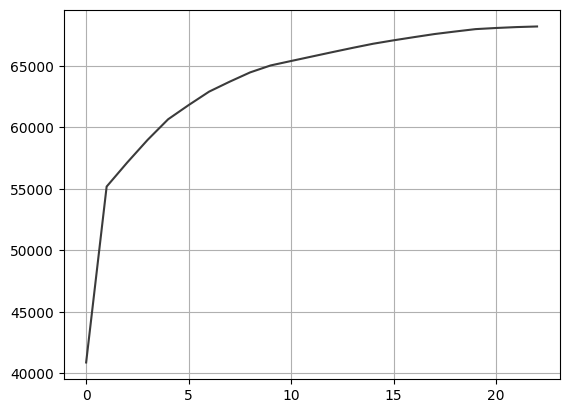

In [24]:
df['OPERA'].value_counts(dropna=False).sort_values(ascending=False).to_frame().T

df.groupby('OPERA').size().reset_index(name='counts').sort_values(by='counts', ascending=False).cumsum().reset_index()['counts'].plot(color='#3B3B3B',grid=True)


In [25]:
# For the origin airport we can see that all the flights are from Santiago (SCL)

display (df.groupby('SIGLAORI').size().reset_index(name='counts'))

display (df
.groupby('SIGLADES')
.size()
.reset_index(name='counts')
.sort_values(by='counts', ascending=False)
)


,SIGLAORI,counts
0,Santiago,68205


,SIGLADES,counts
8,Buenos Aires,6335
0,Antofagasta,5786
28,Lima,5269
9,Calama,5146
42,Puerto Montt,4357
...,...,...
12,Cataratas Iguacu,2
41,"Pisco, Peru",1
44,Puerto Stanley,1
15,Cochabamba,1


array([[<AxesSubplot: title={'center': 'counts'}>]], dtype=object)

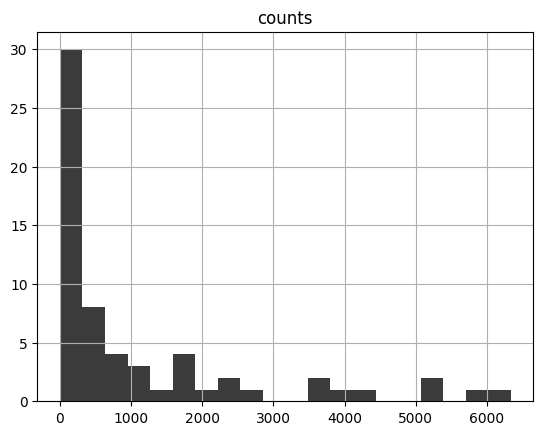

In [26]:
df.groupby('SIGLADES').size().reset_index(name='counts').hist(color=base_color,bins=20)

<AxesSubplot: >

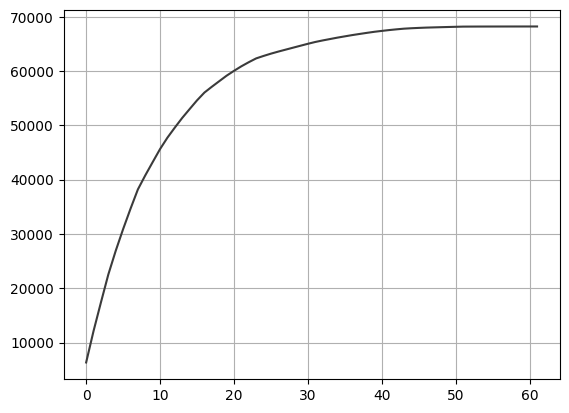

In [27]:
# from the below plot we can see that the top 10 destinations account for about 60% of the total flights
df.groupby('SIGLADES').size().reset_index(name='counts').sort_values(by='counts', ascending=False).cumsum().reset_index()['counts'].plot(color=base_color,grid=True)
# In relation to the target variable it can be expected that on average the delay on the frequent flights is lower than the delay on the less frequent flights. 

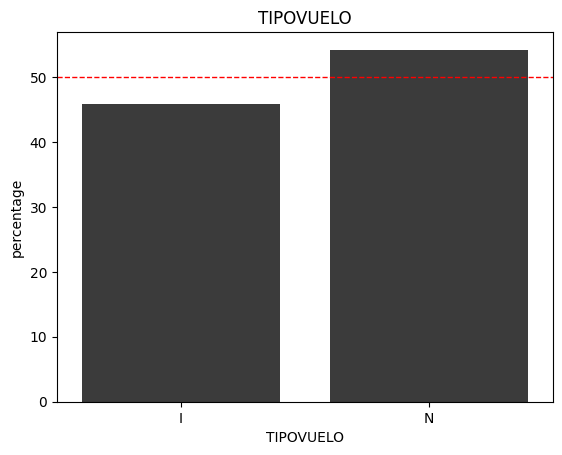

In [28]:
# Regarding the type of flight we can see that the majority of the flights are domestic flights (Nacional)
# but the percentage of international flights is close to half of the domestic flights.
df['TIPOVUELO'].value_counts(dropna=False).to_frame().T
make_bar_plot(df, 'TIPOVUELO', 'TIPOVUELO', key_map={})


## Question 2: 

Generate the following additional columns. Please export them to a CSV file named synthetic_features.csv:


* high_season : 1 if Date-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30, 0 otherwise.
* min_diff : difference in minutes between Date-O and Date-I .
* delay_15 : 1 if min_diff > 15, 0 if not.
* period_day : morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59) and night (between 19:00 and 4:59), based
onDate-I .




In [29]:


df['high_season'] = get_high_season(df)

df[['MES','DIA','high_season']]


,MES,DIA,high_season
0,1,1,1
1,1,2,1
2,1,3,1
3,1,4,1
4,1,5,1
...,...,...,...
68201,12,22,1
68202,12,25,1
68203,12,27,1
68204,12,29,1


In [30]:
# convert df['Fecha-O'] and  df['Fecha-I'] to datetime format 
df['Fecha-O'] = pd.to_datetime(df['Fecha-O'])
df['Fecha-I'] = pd.to_datetime(df['Fecha-I'])

# min_diff : difference in minutes between Date-O and Date-I . 
df['min_diff'] = (df['Fecha-O'] - df['Fecha-I']).dt.total_seconds() / 60

# delay_15 : 1 if min_diff > 15, 0 if not. 
df['delay_15'] = 0
df.loc[df['min_diff'] > 15, 'delay_15'] = 1



In [31]:
# period_day : morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59) and night (between 19:00 and 4:59), based onDate-I use dt.hour to extract the hour.


df['period_day'] = 'morning'
df.loc[(df['Fecha-I'].dt.hour  >= 12) & (df['Fecha-I'].dt.hour  <= 18), 'period_day'] = 'afternoon'
df.loc[(df['Fecha-I'].dt.hour  >= 19) | (df['Fecha-I'].dt.hour  <= 4), 'period_day'] = 'night'


In [32]:
df[['period_day','Fecha-I']].sample(10)

,period_day,Fecha-I
50739,afternoon,2017-10-30 18:10:00
57285,afternoon,2017-11-12 15:30:00
12820,afternoon,2017-03-17 12:50:00
52494,morning,2017-10-24 10:37:00
55946,morning,2017-11-21 10:35:00
62438,night,2017-12-27 01:41:00
45788,morning,2017-09-17 07:45:00
43458,afternoon,2017-08-05 18:10:00
35194,afternoon,2017-07-27 16:59:00
20277,morning,2017-04-11 07:45:00


In [33]:
# list of high_season min_diff delay_15 period_day

synthetic_features_names =  ['high_season', 'min_diff', 'delay_15', 'period_day']

In [34]:
synthetic_features = df[synthetic_features_names]

synthetic_features

,high_season,min_diff,delay_15,period_day
0,1,3.0,0,night
1,1,9.0,0,night
2,1,9.0,0,night
3,1,3.0,0,night
4,1,-2.0,0,night
...,...,...,...,...
68201,1,46.0,1,afternoon
68202,1,16.0,1,afternoon
68203,1,40.0,1,afternoon
68204,1,13.0,0,afternoon


In [35]:
df = df.drop(synthetic_features_names,axis=1)  

In [36]:
df.to_csv('data/interim/dataset_SCL.csv', index=False)
synthetic_features.to_csv('data/interim/synthetic_features_SCL.csv', index=False)

### Question 3:

What is the behavior of the delay rate across destination, airline, month of the year, day of the week, season, type of flight?What
variables would you expect to have the most influence in predicting delays?

In [37]:
from sklearn.model_selection import StratifiedShuffleSplit
import sweetviz as sv


/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
synthetic_features = pd.read_csv('data/interim/synthetic_features_SCL.csv') 
df = pd.read_csv('data/interim/dataset_SCL.csv')


In [39]:
# merge on index 
dataset  = pd.concat([df, synthetic_features], axis=1)


In [40]:
synthetic_features['delay_15'].value_counts(dropna=False).to_frame().T

,0,1
delay_15,55591,12614


In [41]:

# Create the splitter
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

# Loop through the splits

X,y = dataset.drop(['delay_15'] ,axis=1) , dataset['delay_15'] 
for train_index, test_index in splitter.split(X, y):
    # Get the training and test data
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    

In [42]:
# save X_train, X_test, y_train, y_test to csv files in data/interim folder 
X_train.to_csv('data/interim/X_train_SCL.csv', index=False)
X_test.to_csv('data/interim/X_test_SCL.csv', index=False)
y_train.to_csv('data/interim/y_train_SCL.csv', index=False)
y_test.to_csv('data/interim/y_test_SCL.csv', index=False)


In [43]:
## For this analysis only the training data will be used. 

# to avoid possible error for mutability the previous dataframes will be deleted 
del X_train, X_test, y_train, y_test, X, y, df, dataset 

In [44]:
# load the training data 

X_train = pd.read_csv('data/interim/X_train_SCL.csv')
y_train = pd.read_csv('data/interim/y_train_SCL.csv') 

df_train = pd.concat([X_train, y_train], axis=1) 

* the delay rate across 
* destination
* airline
* month of the year
* day of the week
* season
* type of flight

For this plot we will lavarage on the sweetviz library, the complete report can be found in the html file in the reports folder. 


In [45]:
# The column MES_Name is created only for the purpose of the report. 
df_train['MES_Name'] = df_train['MES'].map({1:'Enero',2:'Febrero',3:'Marzo',4:'Abril',5:'Mayo',6:'Junio',7:'Julio',8:'Agosto',9:'Septiembre',10:'Octubre',11:'Noviembre',12:'Diciembre'})


df

In [46]:
my_report = sv.analyze(df_train[['Des-I','Emp-I','Des-O','Emp-O','TIPOVUELO','period_day','high_season','DIANOM','MES_Name','OPERA', 'delay_15']],target_feat='delay_15')

/home/codespace/.python/current/lib/python3.10/site-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/home/codespace/.python/current/lib/python3.10/site-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()
Feature: delay_15 (TARGET)                   |▊         | [  8%]   00:00 -> (00:00 left)/home/codespace/.python/current/lib/python3.10/site-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
Feature: Des-I                               |█▋        | [ 17%]   00:00 -> (00:02 left)/home/codespace/.

In [47]:
my_report.show_html(filepath='./reports/EDA_base_report.html') 

Report ./reports/EDA_base_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


From the image below we can see that there is significant variation in the delay time between the different destinations, hence is a good idea to include this feature in the model.  

The main challenge we face to do it right is the high cardinality of the feature. 
It is not reasonable to create a dummy variable for each destination nor to use an ordinal encoding. 
At this point we have to good alternatives:
1. use a target encoding
2. use WOE encoding 
 
The high cardinality of the feature is still a problem, because it may lead to overfitting. 
because of we will bin the feature in groups an then encode it. 



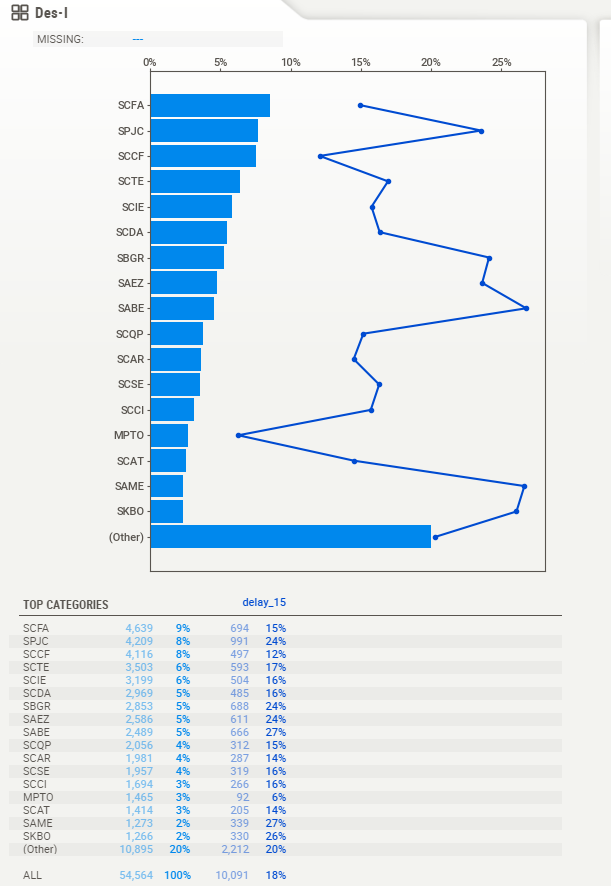

For the airline we have a similar behavior than with the destination, hence we will use the same approach.

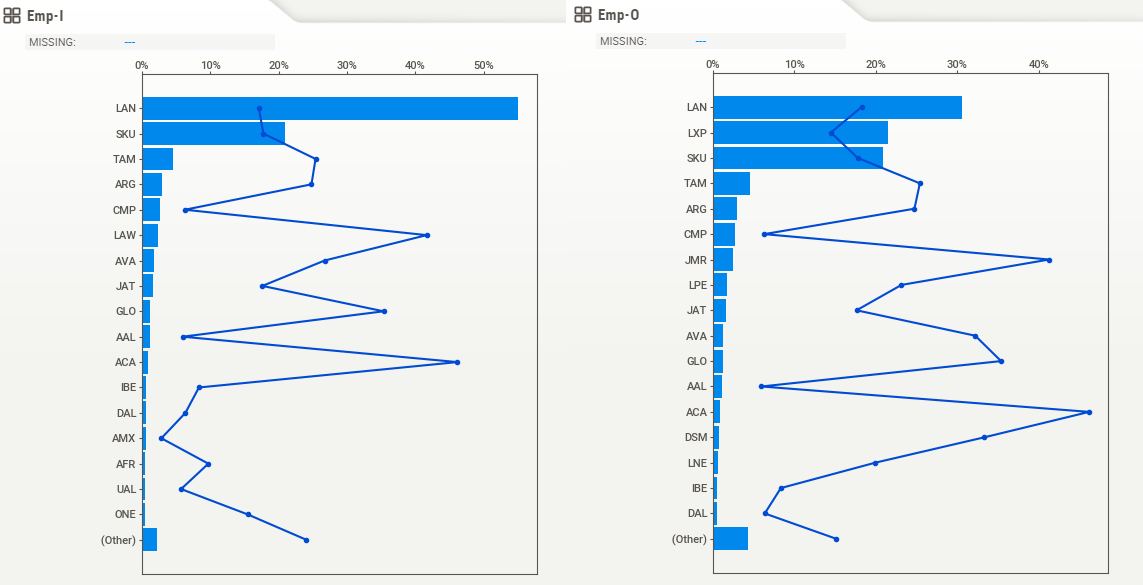

**The Opera column provides a similar information than Emp-I and Emp-O, for the moment we will use the same approach of grouping and encoding and decide on alater stage which one to keep**

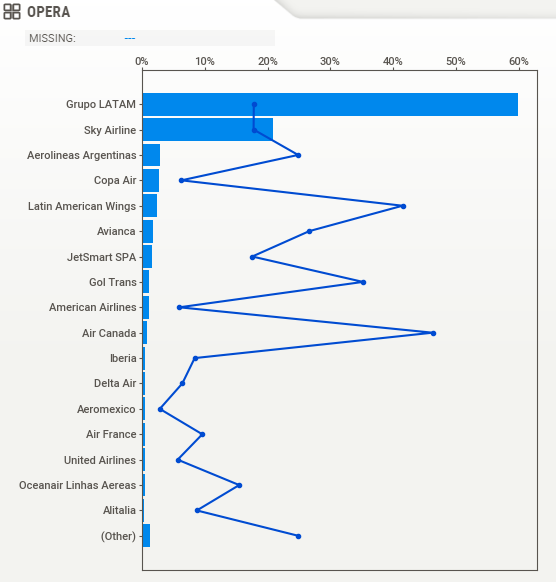

For the month feature there ara also differeces in the delay_15 distribution.  

In particular, the months of December and July have a higher percentage of delays.
mayube related to a higher demand of flights in these months. 

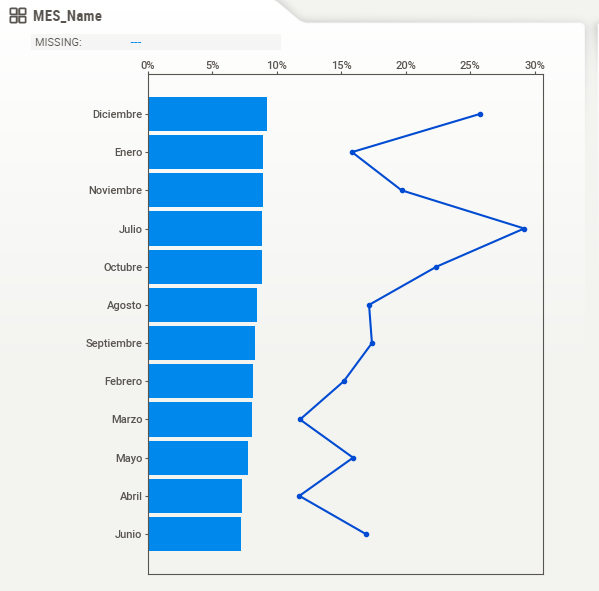

For the type of flight  the analysis is straighforward, on average the delay is higher for international flights than for domestic flights. 

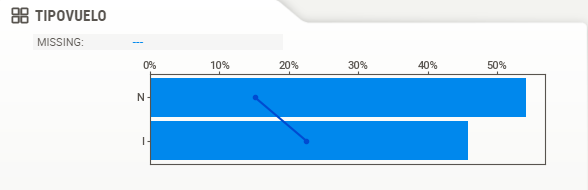

During the high season the delays rate is larger 

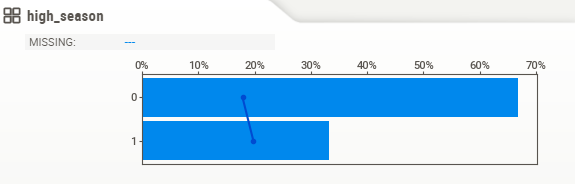

Regarding the Period of the day, during the morning the rate of delays is smaller hence this is a variable that could be used for the model

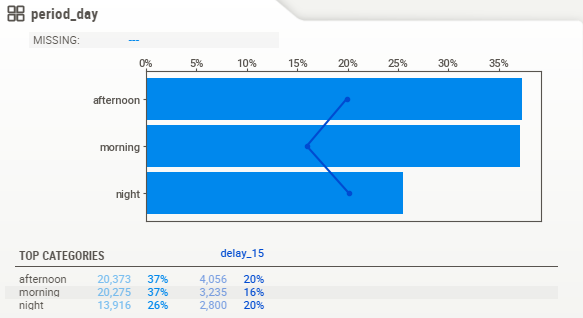

For the day of the week we can also see relation with the delay, for this variable we will just make a flag for the days with Longer delay: 

long_delay_day: Jueves, Viernes, Lunes 


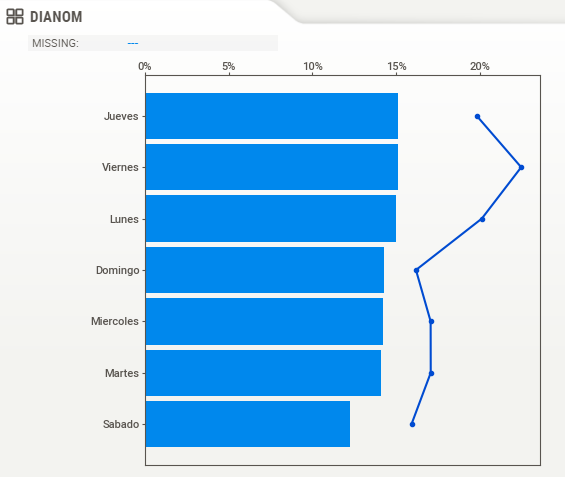

In [46]:
# count unique values for each column 

df_train[['Emp-I','Emp-O','OPERA']].nunique()

Emp-I    30
Emp-O    31
OPERA    23
dtype: int64

### Feature Engineering 

In [47]:
fligths_th = 100


main_destination =  df_train['Des-I'].value_counts().loc[lambda x: x > fligths_th].index

# create a default dictionary with main_destination as keys if the k is in the list return the same k, if not return 'other' 
destination_mapping = defaultdict(lambda: 'other')
for k in main_destination:
    destination_mapping[k] = k


# save destination_mapping to as a json file in the data/processed folder 
import json
with open('data/processed/destination_mapping_SCL.json', 'w') as fp:
    json.dump(destination_mapping, fp)


In [48]:
# For the airline we will use the same approach, with the difference that we will have to work with to columns Emp-I and Emp-O. 
# ideally both shlould be the same, but close to the date of this dataset there was a merge between airlines I'm asuming that's the reason for the discrepancy.
# Using both variables in the model does not sound like a great idea, since it will add complexity ahard to justify 
# but we will create both and see which performs better. 




In [49]:
# select the airlines with more than 100 flights use the value_counts method 
main_airline_I = df_train['Emp-I'].value_counts().loc[lambda x: x > fligths_th].index

# do the same for Emp-O
main_airline_O = df_train['Emp-O'].value_counts().loc[lambda x: x > fligths_th].index

main_airline = main_airline_I.append(main_airline_O).unique()

main_airline

# create a default dictionary with main_airline as keys if the k is in the list return the same k, if not return 'other'
airline_mapping = defaultdict(lambda: 'other')
for k in main_airline:
    airline_mapping[k] = k

# save airline_mapping to as a json file in the data/processed folder
with open('data/processed/airline_mapping_SCL.json', 'w') as fp:
    json.dump(airline_mapping, fp)
    


In [50]:
## repeat the process for the OPERA column
main_airline_op = df_train['OPERA'].value_counts().loc[lambda x: x > fligths_th].index

airline_mapping_op = defaultdict(lambda: 'other')
for k in main_airline_op:
    airline_mapping_op[k] = k

# save airline_mapping to as a json file in the data/processed folder
with open('data/processed/airline_mapping_op_SCL.json', 'w') as fp:
    json.dump(airline_mapping_op, fp)



In [51]:
df_train.columns


Index(['Fecha-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Ori-O', 'Des-O',
       'Emp-O', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO', 'OPERA',
       'SIGLAORI', 'SIGLADES', 'year', 'month', 'high_season', 'min_diff',
       'period_day', 'delay_15', 'MES_Name'],
      dtype='object')

In [52]:
# longer delays this is defined by the analisys of the plots in the EDA report 

longer_delay_days = ['Jueves','Viernes','Lunes'] 
# save longer_delay_days to as a json file in the data/processed folder 

longer_delay_days = {'Lunes': 1,
 'Martes': 0,
 'Miercoles': 0,
 'Jueves': 1,
 'Viernes': 1,
 'Sabado': 0,
 'Domingo': 0}
 
with open('data/processed/longer_delay_days_SCL.json', 'w') as fp:
    json.dump(longer_delay_days, fp)




In [53]:
# longer delay months 

# 3: Julio ,Octubre, Noviembre, Diciembre
# 2: Enero, Agosto, Septiembre, Febrero, Mayo, Junio
# 1: Marzo, Abril

longer_delay_months= {'Julio': 3,
 'Octubre': 3,
 'Noviembre': 3,
 'Diciembre': 3,
 'Enero': 2,
 'Agosto': 2,
 'Septiembre': 2,
 'Febrero': 2,
 'Mayo': 2,
 'Junio': 2,
 'Marzo': 1,
 'Abril': 1}

longer_delay_months= {7: 3, 10: 3, 11: 3, 12: 3, 1: 2, 8: 2, 9: 2, 2: 2, 5: 2, 6: 2, 3: 1, 4: 1}
#save longer_delay_months to as a json file in the data/processed folder

with open('data/processed/longer_delay_months_SCL.json', 'w') as fp:
    json.dump(longer_delay_months, fp)


In [54]:

features = ['Des-I', 'Emp-I',   'Des-O',
       'Emp-O',  'MES',  'DIANOM', 'TIPOVUELO', 'OPERA',
       'SIGLADES',  'month', 'high_season', 
       'period_day', 'delay_15']
       
df_train = df_train[features]
#def map_columns(df, mapping, columns):
#  for col in columns:
#    df[col] = df[col].map(mapping)
    

In [55]:
df_train[features]

# map the values in the columns Des-I, Emp-I, Des-O, Emp-O, OPERA using the dictionaries created before
df_train['Des-I'] = df_train['Des-I'].map(destination_mapping)
df_train['Emp-I'] = df_train['Emp-I'].map(airline_mapping)
df_train['Des-O'] = df_train['Des-O'].map(destination_mapping)
df_train['Emp-O'] = df_train['Emp-O'].map(airline_mapping)
df_train['OPERA'] = df_train['OPERA'].map(airline_mapping_op)


    



In [56]:
df_train.head()

,Des-I,Emp-I,Des-O,Emp-O,MES,DIANOM,TIPOVUELO,OPERA,SIGLADES,month,high_season,period_day,delay_15
0,SPJC,SKU,SPJC,SKU,11,Jueves,I,Sky Airline,Lima,11,0,night,1
1,SCIE,LAW,SCIE,JMR,4,Jueves,N,Latin American Wings,Concepcion,4,0,afternoon,0
2,MPTO,CMP,MPTO,CMP,6,Jueves,I,Copa Air,Ciudad de Panama,6,0,night,1
3,SCTE,LAN,SCTE,LXP,6,Jueves,N,Grupo LATAM,Puerto Montt,6,0,afternoon,1
4,SBGR,TAM,SBGR,TAM,6,Jueves,I,Grupo LATAM,Sao Paulo,6,0,afternoon,0


In [57]:
# map the values in the columns DIANOM and  MES
df_train['DIANOM'] = df_train['DIANOM'].map(longer_delay_days)
df_train['MES'] = df_train['MES'].map(longer_delay_months)



In [58]:

my_report = sv.analyze(df_train,target_feat='delay_15')
my_report.show_html(filepath='./reports/EDA_mod_report.html') 


/home/codespace/.python/current/lib/python3.10/site-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/home/codespace/.python/current/lib/python3.10/site-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()
Feature: delay_15 (TARGET)                   |▋         | [  7%]   00:00 -> (00:02 left)/home/codespace/.python/current/lib/python3.10/site-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
Feature: Des-I                               |█▍        | [ 14%]   00:00 -> (00:03 left)/home/codespace/.

Report ./reports/EDA_mod_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


**In the bellow images we can see the variables that were more affected by the mapping:** 

The variable month now has a linear relation of its value (1,2,3) and the increase in the rate of delays.  

It might even be more relevant to the model than the hihg_season variable.  

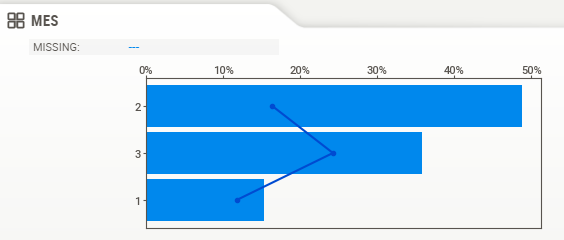


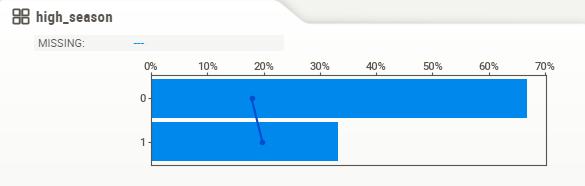

The day variable also has now a clear relation with the target variable 

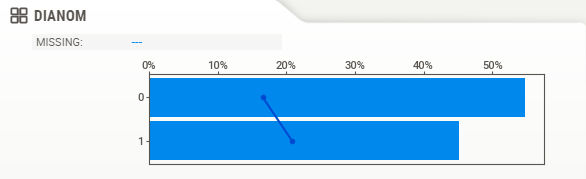

For the rest of the features is still required to apply a target encoding. 

Regarding the variables that may have the larget impact on the model: 

* Mes: I expect this variable to have a large impact on the model. 

* TIPOVUELO: I expect this variable to have a large impact on the model.

* OPERA (And similar): There is a large variance of the delay rate across the airlines, which is a good sign for the model. But they also have a large cardinality and are largely invalanced, so may need further work in order to encode the information propertly. 

* SIGLADES (And similar): Similarly to the opera variable there is a large variance of the delay rate and a high cardinality, with the advantage of been more balanced that 'OPERA'. The disadvantage is that a large proportion of its information may be already encoded in the variable 'TIPOVUELO'


# Question 4: 

 Train one or several models (using the algorithm(s) of your choice) to estimate the likelihood of a flight delay.
Feel free to generate additional variables and/or supplement with external variables.

In [60]:
df_train

# split the data into train and validation 

from sklearn.model_selection import train_test_split

#ce.fit_transform#(X[, y])
import category_encoders as ce

woee =  ce.woe.WOEEncoder()


In [61]:
X = df_train.drop('delay_15', axis=1)
y = df_train['delay_15']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0,stratify=y)


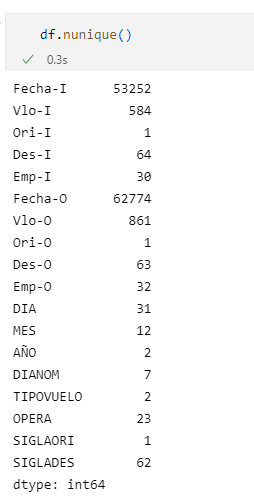